# Fair Value Gap - Analytics

### Import Library

In [6]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
from candlestick import WHITE_CS, BLACK_CS, DOJI_CS

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [7]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [8]:
data = dataset.copy()

In [9]:
def fvg_modeling(htd):
    """ fair_value_gap """
    data = htd.copy()
    data["oc_dif"] = data.apply(lambda r: r['Close'] - r['Open'], axis=1)
    data['color'] = data.apply(
        lambda r: DOJI_CS if r['oc_dif'] == 0 else (
            WHITE_CS if r['oc_dif'] > 0 else BLACK_CS), axis=1)
    data['color_prev_1'] = data['color'].shift(1)
    data['color_prev_2'] = data['color'].shift(2)
    data['high_prev_2'] = data['High'].shift(2)
    data['low_prev_2'] = data['Low'].shift(2)
    data.dropna(inplace=True)
    data['fvg'] = data.apply(lambda r: cal_fvg(r), axis=1)
    data.drop(columns=['color', 'color_prev_1', 'color_prev_2', 'high_prev_2', 'low_prev_2', 'oc_dif'], inplace=True)
    return data

In [10]:
def cal_fvg(r):
    fvg = ''
    if r['color_prev_1'] == WHITE_CS and r['color'] == WHITE_CS \
            and r['high_prev_2'] < r['Low'] - 0.1:
        fvg = 'fvg_up'
    elif r['color_prev_1'] == BLACK_CS and r['color'] == BLACK_CS \
            and r['low_prev_2'] > r['High'] + 0.1:
        fvg = 'fvg_down'
    return fvg

In [11]:
data = fvg_modeling(data)

In [12]:
data['min_3_low'] = data['Low'].rolling(3).min()
data['max_3_high'] = data['High'].rolling(3).max()

In [13]:
data.dropna(inplace=True)

In [14]:
data

,Open,High,Low,Close,Volume,fvg,min_3_low,max_3_high
Date,,,,,,,,
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765,,942.3,943.7
2018-08-13 09:25:00,943.8,945.9,943.7,945.3,2469,fvg_up,942.3,945.9
2018-08-13 09:30:00,945.2,945.5,943.9,944.0,1668,,942.4,945.9
2018-08-13 09:35:00,944.0,944.5,943.7,943.7,1543,,943.7,945.9
2018-08-13 09:40:00,943.8,944.8,943.3,944.5,1722,,943.3,945.5
...,...,...,...,...,...,...,...,...
2024-09-18 14:15:00,1310.7,1313.5,1308.7,1312.8,8783,,1308.7,1313.5
2024-09-18 14:20:00,1312.8,1313.2,1310.8,1311.3,6209,,1308.7,1313.5
2024-09-18 14:25:00,1311.1,1313.3,1311.1,1311.2,5452,,1308.7,1313.5


### Calculating return

In [15]:
RR = 3
def cal_return(data):
    data['return'] = ''
    data['exit_time'] = ''
    data['entry_price'] = ''
    data['exit_price'] = ''
    data['deal_type'] = ''
    data['sl_length'] = ''
    data['min_max_length'] = ''
    for i, row in data.iterrows():
        if 910 < 100*row.name.hour + row.name.minute < 1430:
            if row['fvg'] != '':
                _return = 0
                current_date = row.name.strftime('%Y-%m-%d ').format()
                current_time = row.name
                entry_price = max_price = min_price = row['Close']
                data_from_start_day = data[(data.index < current_time) & (data.index > current_date + ' 08:59:00')]
                if 100*row.name.hour + row.name.minute < 1405:
                    if row['fvg'] == 'fvg_up':
                        deal_type = 'long'
                        stoploss = row['min_3_low']
                        sl_length = entry_price - stoploss
                        min_max_length = entry_price - data_from_start_day['Low'].min()
                    else:
                        deal_type = 'short'
                        stoploss = row['max_3_high']
                        sl_length = stoploss - entry_price
                        min_max_length = data_from_start_day['High'].max() - entry_price
                exit_time = ''
                exit_price = 0
                data_to_end_day = data[(data.index > current_time) & (data.index < current_date + ' 14:30:00')]
                for k, wrow in data_to_end_day.iterrows():
                    if deal_type == 'long':
                        if wrow['Low'] < stoploss:
                            # if max_price >= entry_price + RR * sl_length:
                            #     # Take profit
                            #     _return = RR * sl_length
                            #     exit_time = wrow.name
                            #     exit_price = entry_price + RR * sl_length
                            # else:
                                # Stoploss
                            if max_price < entry_price + sl_length:
                                # if profit >= stoploss, keep deal as has profit
                                # else do stoploss
                                _return = stoploss - entry_price
                                exit_time = wrow.name
                                exit_price = wrow['Low']
                            else:
                                _return = max_price - entry_price
                            break
                        else:
                            if wrow['High'] > max_price:
                                max_price = wrow['High']
                                exit_time  = wrow.name
                                exit_price = max_price
                            if 100*row.name.hour + row.name.minute == 1425:
                                _return = max_price - entry_price
                                break
                    if deal_type == 'short':
                        if wrow['High'] > stoploss:
                            if min_price > entry_price - sl_length:
                                # if profit >= stoploss, keep deal as has profit
                                # else do stoploss
                                _return = entry_price - stoploss
                                exit_time = wrow.name
                                exit_price = stoploss
                            else:
                                _return = entry_price - min_price
                            break
                        else:
                            if wrow['Low'] < min_price:
                                min_price = wrow['Low']
                                exit_time  = wrow.name
                                exit_price = min_price
                            if 100*row.name.hour + row.name.minute == 1425:
                                _return = entry_price - min_price
                                break
                data.at[i, 'deal_type'] = deal_type
                data.at[i, 'entry_price'] = entry_price
                data.at[i, 'return'] = _return
                data.at[i, 'exit_price'] = exit_price
                data.at[i, 'exit_time'] = exit_time
                data.at[i, 'sl_length'] = sl_length
                data.at[i, 'min_max_length'] = min_max_length
    return data

In [16]:
data = cal_return(data)

In [17]:
has_return = data[(data['return'] != '') & (data['return'] != 0)]

In [18]:
has_return

,Open,High,Low,Close,Volume,fvg,min_3_low,max_3_high,return,exit_time,entry_price,exit_price,deal_type,sl_length,min_max_length
Date,,,,,,,,,,,,,,,
2018-08-13 10:25:00,944.0,944.2,943.5,943.9,1538,fvg_down,943.5,945.7,-1.8,2018-08-13 11:10:00,943.9,945.7,short,1.8,2.5
2018-08-14 10:15:00,956.6,957.3,956.3,957.1,1335,fvg_up,955.0,957.3,-2.1,2018-08-14 10:35:00,957.1,953.0,long,2.1,2.8
2018-08-14 10:40:00,953.4,953.7,952.6,952.9,2550,fvg_down,952.6,956.1,-3.2,2018-08-14 13:15:00,952.9,956.1,short,3.2,4.4
2018-08-14 11:10:00,952.9,953.3,952.1,952.3,1416,fvg_down,952.1,954.4,-2.1,2018-08-14 11:25:00,952.3,954.4,short,2.1,5.0
2018-08-15 09:15:00,960.3,961.1,960.3,960.7,1413,fvg_up,958.6,961.1,-2.1,2018-08-15 10:50:00,960.7,957.5,long,2.1,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-16 10:10:00,1296.3,1296.7,1296.2,1296.6,1558,fvg_up,1295.4,1297.4,-1.2,2024-09-16 10:20:00,1296.6,1294.7,long,1.2,3.6
2024-09-17 10:05:00,1284.5,1285.3,1284.3,1285.0,4205,fvg_up,1283.0,1285.3,-2.0,2024-09-17 10:50:00,1285.0,1282.7,long,2.0,2.8
2024-09-18 09:20:00,1304.2,1304.2,1303.2,1303.5,2921,fvg_down,1303.2,1305.4,-1.9,2024-09-18 09:30:00,1303.5,1305.4,short,1.9,2.2


In [19]:
has_return['return'].sum()

-6294.100000000043

In [20]:
long = has_return[has_return['deal_type'] == 'long']

In [21]:
long.tail(30)

,Open,High,Low,Close,Volume,fvg,min_3_low,max_3_high,return,exit_time,entry_price,exit_price,deal_type,sl_length,min_max_length
Date,,,,,,,,,,,,,,,
2024-08-26 10:35:00,1319.9,1320.8,1319.9,1320.5,4272,fvg_up,1318.6,1320.8,2.6,2024-08-26 13:10:00,1320.5,1323.1,long,1.9,2.3
2024-08-26 11:00:00,1320.0,1320.9,1319.9,1320.2,2730,fvg_up,1319.0,1320.9,2.9,2024-08-26 13:10:00,1320.2,1323.1,long,1.2,2.0
2024-08-26 13:05:00,1321.2,1322.5,1321.2,1322.2,3821,fvg_up,1320.2,1322.5,-2.0,2024-08-26 13:30:00,1322.2,1319.6,long,2.0,4.0
2024-08-26 13:10:00,1322.2,1323.1,1322.0,1322.6,4764,fvg_up,1320.2,1323.1,-2.4,2024-08-26 13:30:00,1322.6,1319.6,long,2.4,4.4
2024-08-26 14:10:00,1319.3,1319.3,1316.3,1316.8,12673,fvg_down,1316.3,1322.3,3.4,2024-08-26 14:15:00,1316.8,1316.2,long,2.4,4.4
2024-08-27 10:10:00,1317.9,1319.2,1317.9,1319.2,5208,fvg_up,1317.0,1319.2,-2.2,2024-08-27 10:45:00,1319.2,1316.6,long,2.2,3.6
2024-08-27 10:15:00,1319.1,1319.8,1318.8,1319.6,4188,fvg_up,1317.1,1319.8,-2.5,2024-08-27 10:40:00,1319.6,1317.0,long,2.5,4.0
2024-08-28 10:40:00,1322.4,1322.9,1322.2,1322.8,1874,fvg_up,1321.5,1322.9,1.8,2024-08-28 11:00:00,1322.8,1324.6,long,1.3,2.2
2024-08-28 13:25:00,1320.8,1322.2,1320.8,1321.6,5924,fvg_up,1319.3,1322.2,-2.3,2024-08-28 13:55:00,1321.6,1318.5,long,2.3,4.6


In [22]:
long['sl_length'] = long['sl_length'].astype(float)

In [23]:
long['sl_group'] = pd.qcut(long.sl_length, 20)

In [24]:
long['min_max_length'] = long['min_max_length'].astype(float)

In [25]:
long['return'] = long['return'].astype(float)

In [26]:
long['min_max_group'] = pd.qcut(long.min_max_length, 20)

In [27]:
long['sl_length'].describe()

count    2700.000000
mean        3.770815
std         2.738162
min         0.500000
25%         2.000000
50%         3.100000
75%         4.700000
max        26.700000
Name: sl_length, dtype: float64

In [28]:
long['return'].describe()

count    2700.000000
mean       -1.369963
std         5.512616
min       -26.700000
25%        -4.100000
50%        -2.250000
75%         1.200000
max        51.400000
Name: return, dtype: float64

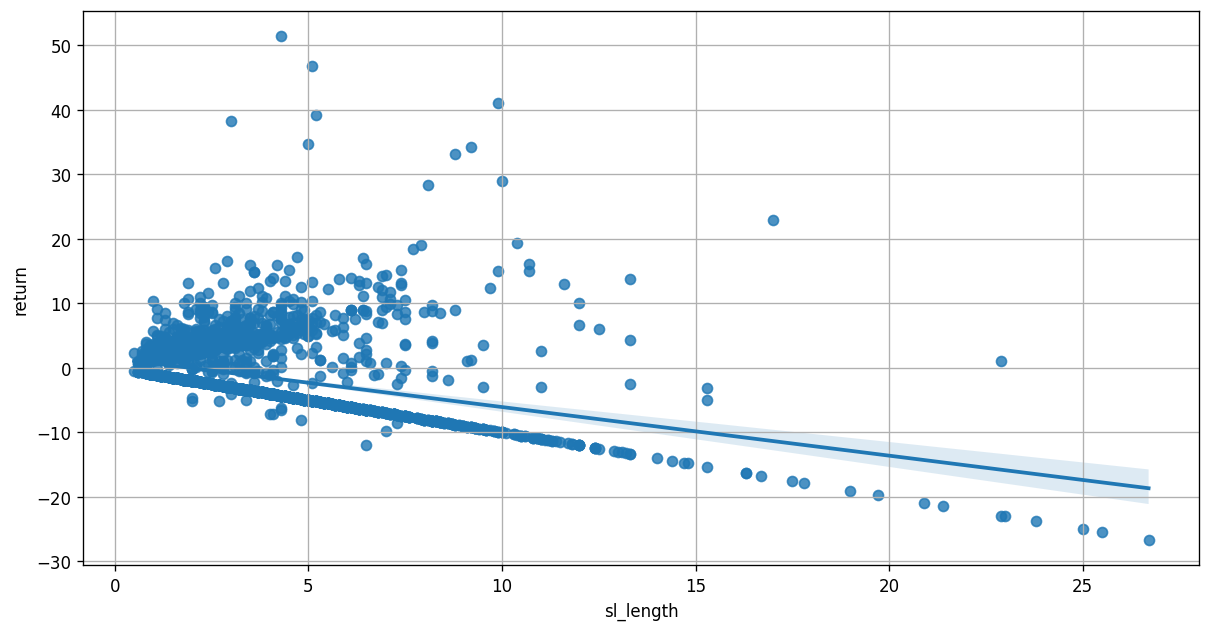

In [29]:
sns.regplot(x=long['sl_length'], y=long['return'])
plt.grid(True)

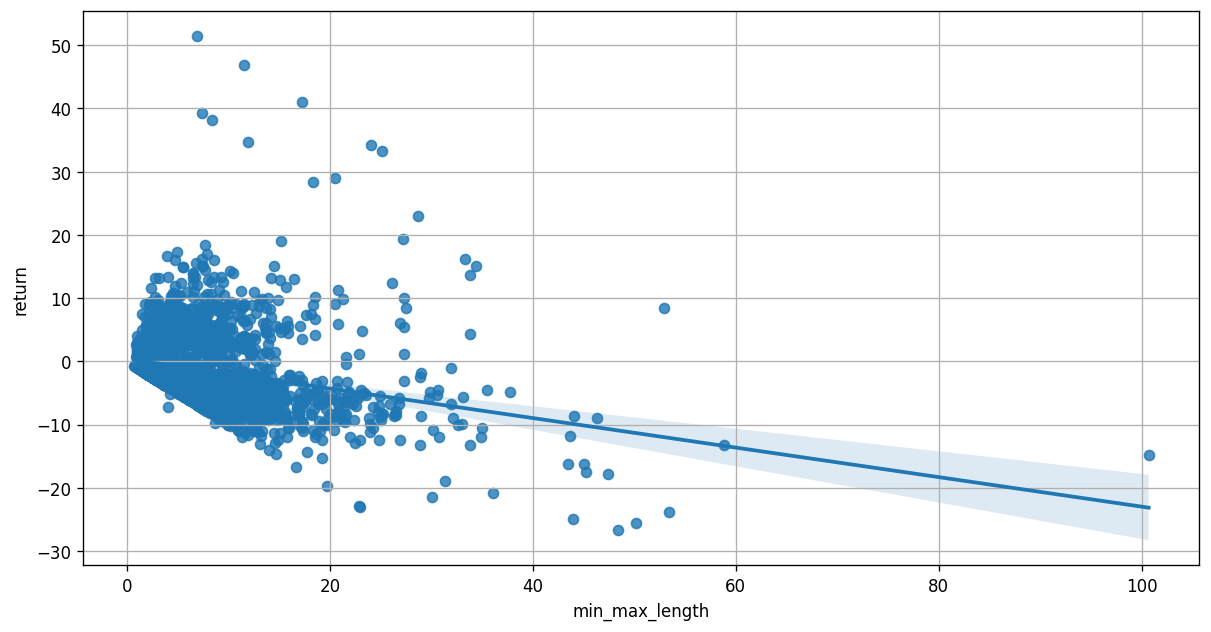

In [30]:
sns.regplot(x=long['min_max_length'], y=long['return'])
plt.grid(True)

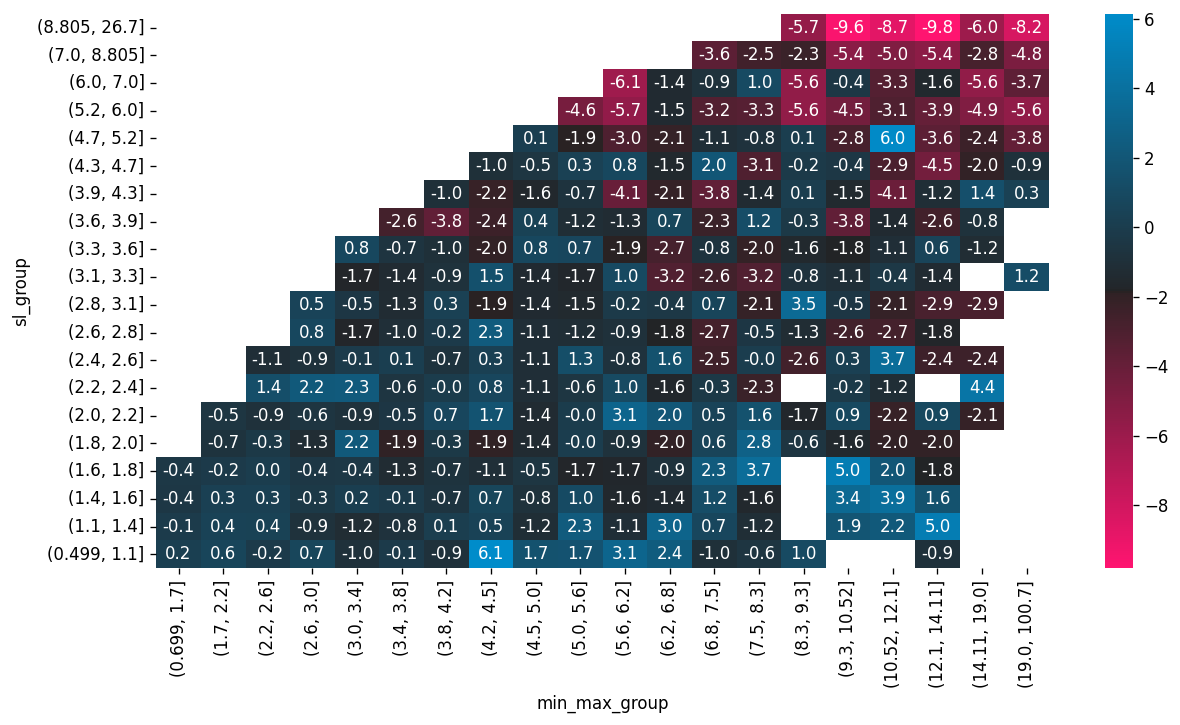

In [31]:
grpd = long.groupby(['sl_group', 'min_max_group'])[['return']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='sl_group', columns='min_max_group', values='return').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");